In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log

In [2]:
image = cv2.imread('test3.jpg')

In [3]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

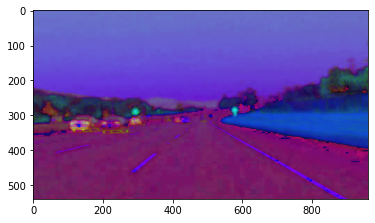

In [4]:
def convolve(img, kernel):
    x_kernel = kernel.shape[0]
    y_kernel = kernel.shape[1]
    x_image = img.shape[0]
    y_image = img.shape[1]
    
    output = np.zeros_like(img)

    for i in range(3):
        for y in range(y_image-y_kernel+1):
            for x in range(x_image-x_kernel+1):
                output[x, y, i] = (kernel * img[x: x + x_kernel, y: y + y_kernel, i]).sum()/(kernel.sum())

    return output


def applyGaussian(img, sig, t):
    sHalf = round(sqrt(-log(t)*2*(sig**2)))
    x, y = np.mgrid[-sHalf:sHalf+1, -sHalf:sHalf+1]
    g =  np.exp(-((x**2 + y**2) / (2.0*sig**2)))

#     output = convolve(img, g)
    output = cv2.GaussianBlur(img, (7, 7), 0)


    return output


smooth_img = applyGaussian(img, 1, 0.5)
plt.imshow(img)
plt.show()

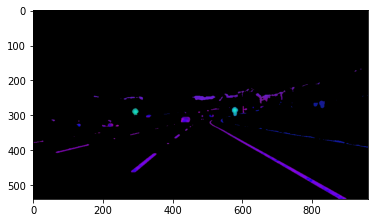

In [5]:
def applyMask(img):
    mask_white = cv2.inRange(img, np.array([0, 0, 140]), np.array([255, 30, 255]))
    mask_yellow = cv2.inRange(img, np.array([20, 100, 100]), np.array([30, 255, 255]))
    mask = cv2.bitwise_or(mask_white, mask_yellow)
    return cv2.bitwise_and(img, img, mask=mask)


img = applyMask(smooth_img)


plt.imshow(img, cmap="gray")
plt.show()

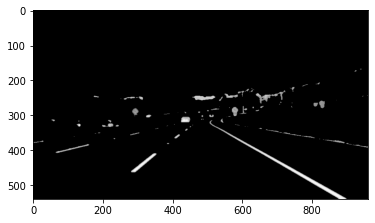

In [6]:
img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap="gray")
plt.show()

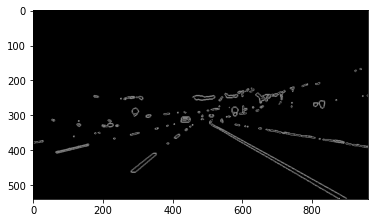

In [8]:
def getEdges(img):
    return cv2.Canny(img, 50, 150)

img = getEdges(img)
plt.imshow(img, cmap="gray")
plt.show()

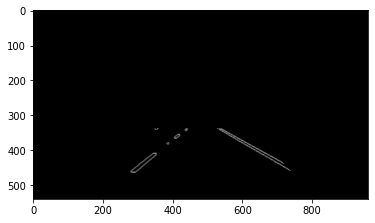

In [9]:
def applyROI(img):
    image_x = img.shape[0]
    image_y = img.shape[1]

    roi = np.zeros_like(img)

    for i in range(image_y):
        for j in range(image_x):
            if (j>image_x/1.6) and (i>image_y/1.5-j/1.1) and (i<image_y-image_y/1.5+j/1.1):
                roi[j, i] = 255

    img = cv2.bitwise_and(img, roi)

    plt.imshow(img, cmap="gray")
    plt.show()

    return img

img = applyROI(img)

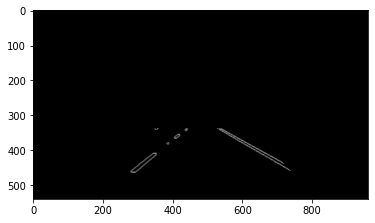

In [10]:
plt.imshow(img, cmap="gray")
plt.show()

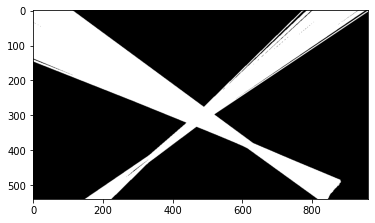

In [12]:
def houghTransform(img):
    image_x = img.shape[0]
    image_y = img.shape[1]

    diag = int(np.ceil(np.sqrt((image_x - 1)**2 + (image_y - 1)**2)))

    H = np.zeros((360, 2*diag))

    for i in range(image_y):
        for j in range(image_x):
            if img[j, i]==255:
                for theeta in range(360):
                    value = i*np.cos(theeta) + j*np.sin(theeta)
                    H[theeta, int(value+diag)] += 1

    output = np.zeros_like(img)

    lines = []
    
    threshold = np.amax(H)/6

    for t in range(360):
        for d in range(diag*2):
            if H[t, d] >= threshold:
                rho = d-diag
                a = np.cos(t)
                b = np.sin(t)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                cv2.line(output,(x1,y1),(x2,y2),255,2)
                lines.append((x1,y1,x2,y2))

    plt.imshow(output, cmap="gray")
    plt.show()

    return lines

lines = houghTransform(img)

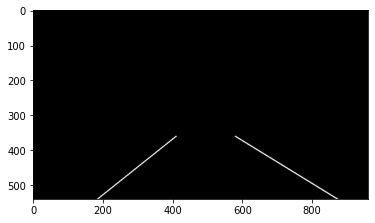

In [13]:
def applyRegression(img, lines):
    left_lines = [[], []]
    right_lines = [[], []]

    for each in lines:
        x0, y0, x1, y1 = each
        m = (y1-y0)/(x1-x0)

        if m < -0.5:
            left_lines[0].append(x0)
            left_lines[0].append(x1)
            left_lines[1].append(y0)
            left_lines[1].append(y1)
            
        if m > 0.5:
            right_lines[0].append(x0)
            right_lines[0].append(x1)
            right_lines[1].append(y0)
            right_lines[1].append(y1)


    def calc(x, y):
        n = len(x)
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        x_y = sum([a*b for a, b in zip(x, y)])
        x_x = sum([a**2 for a in x])
        m = (x_y-n*x_mean*y_mean)/(x_x-n*x_mean*x_mean)
        c = y_mean-m*x_mean
        return m, c

    left_m, left_c = calc(left_lines[0], left_lines[1])
    right_m, right_c = calc(right_lines[0], right_lines[1])

    output = np.zeros_like(img)

    points = []

    def draw(m, c):
        y0 = int(len(img)/1.5)
        y1 = int(len(img))
        x0 = int((y0-c)/m)
        x1 = int((y1-c)/m)
        points.append([(x0,y0), (x1,y1)])
        cv2.line(output, (x0,y0), (x1,y1), 255, 2)

    draw(left_m, left_c)
    draw(right_m, right_c)
    
    plt.imshow(output, cmap="gray")
    plt.show()

    return points

points = applyRegression(img, lines)

In [14]:
def drawLines(img, points):
    output = np.zeros_like(img)

    output = cv2.line(output, points[0][0], points[0][1], (0, 255, 0), 5)
    output = cv2.line(output, points[1][0], points[1][1], (0, 255, 0), 5)

    return cv2.addWeighted(img, 0.8, output, 1, 0)

final = drawLines(image, points)

plt.imshow(final)
plt.show()